In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df=pd.read_excel('insurance-cost-prediction.xlsm')
display(df.shape)
# Droping duplicates
df=df.drop_duplicates()
df[df.duplicated()]
df.head(3)

(1338, 7)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [7]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
categorical_features=['sex','smoker','region']
numerical_features=['age','bmi','children','charges'] 

# Categorical to categorical variables relationship.
from scipy.stats import chi2_contingency
# Chi-square for cat-to-cat column relationship
def find_categorical_columns_relation(df, col1, col2):
    confusion_matrix=pd.crosstab(df[col1], df[col2])
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim))
    #print('col1:', col1, ',col2:', col2, ',Cramers V:', cramers_v)
    return cramers_v # 0 means no relation and 1 means strong relation. It does not show direction of relation (positive or negative)

#find_categorical_columns_relation(df,'workclass','income')
def already_computed(col1, col2):
    if (col1, col2) in computed or (col2, col1) in computed:
        return False
    else:
        computed.add((col1, col2))
        return True

lst=[]
computed=set()
for cat_col1 in categorical_features:
    for cat_col2 in categorical_features:
        if cat_col1 != cat_col2 and already_computed(cat_col1, cat_col2):
            cramers_v=find_categorical_columns_relation(df, cat_col1, cat_col2)
            lst.append((cat_col1, cat_col2, cramers_v))
sorted_lst=sorted(lst, key=lambda x: x[2], reverse=True)
for item in sorted_lst:
    print(item)

('sex', 'smoker', 0.07474283675068631)
('smoker', 'region', 0.07377978990310645)
('sex', 'region', 0.018886535810146383)


In [137]:
# Numerical columns correlation with categorical columns
def correlation_ratio(df, cat_col, num_col):
    categories = np.array(df[cat_col])
    values = np.array(df[num_col])

    cat_means = [
        values[categories == cat].mean()
        for cat in np.unique(categories)
    ]

    grand_mean = values.mean()
    numerator = sum(
        len(values[categories == cat]) * (mean - grand_mean) ** 2
        for cat, mean in zip(np.unique(categories), cat_means)
    )
    denominator = sum((values - grand_mean) ** 2)
    result = numerator / denominator
    return result # 0 means no relation and 1 means strong relation. It does not show direction of relation (positive or negative

lst=[]
for cat_col in categorical_features:
    for num_col in numerical_features:
        eta_sq=correlation_ratio(df, cat_col, num_col)
        lst.append((cat_col, num_col, eta_sq))

sorted_lst=sorted(lst, key=lambda x: x[2], reverse=True)
for item in sorted_lst:
    print(item[0], item[1], f"{item[2]:.10f}")

smoker charges 0.6197379490
region bmi 0.0816129926
region charges 0.0065423766
sex charges 0.0033691635
sex bmi 0.0021526872
region children 0.0016745327
smoker age 0.0006547006
sex age 0.0003925770
sex children 0.0003185347
region age 0.0001817346
smoker children 0.0000537468
smoker bmi 0.0000140341


In [139]:
# Calculate vif among numerical features
from statsmodels.stats.outliers_influence import variance_inflation_factor 

X = df[['age','bmi','children']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

display(vif_data.sort_values(by='VIF', ascending=False))

,Feature,VIF
1,bmi,7.856685
0,age,7.542947
2,children,1.797373


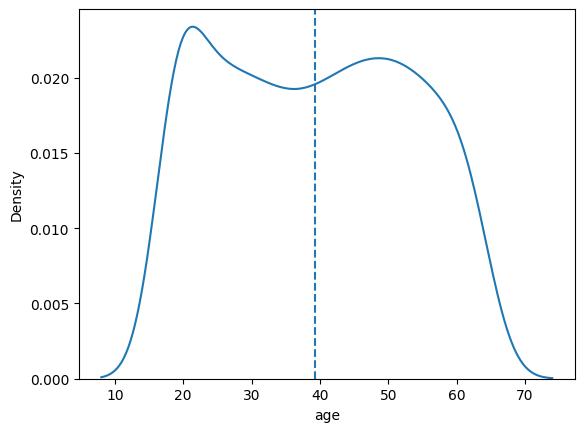

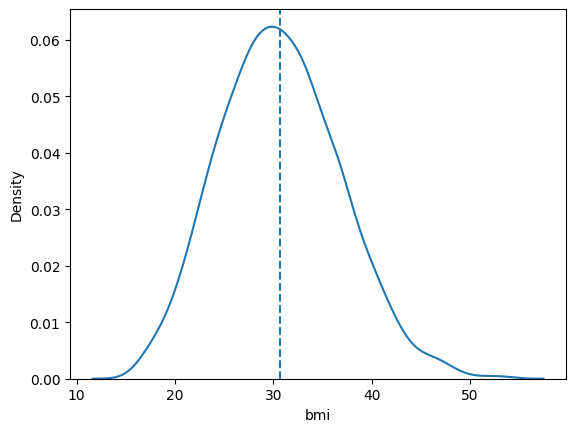

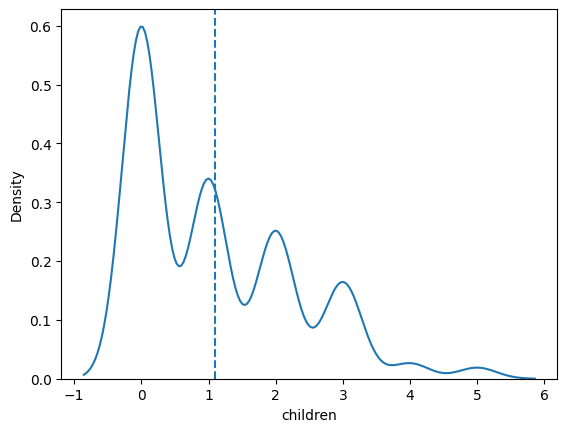

In [140]:
#Numerical data distribution.
def draw_distribution(df, col):
    mean_val = df[col].mean()
    sns.kdeplot(df[col])
    plt.axvline(mean_val, linestyle='--', label=f'Mean = {mean_val:.2f}')
    plt.show()

plt.clf()
for num_col in ['age','bmi','children']:
    draw_distribution(df, num_col)

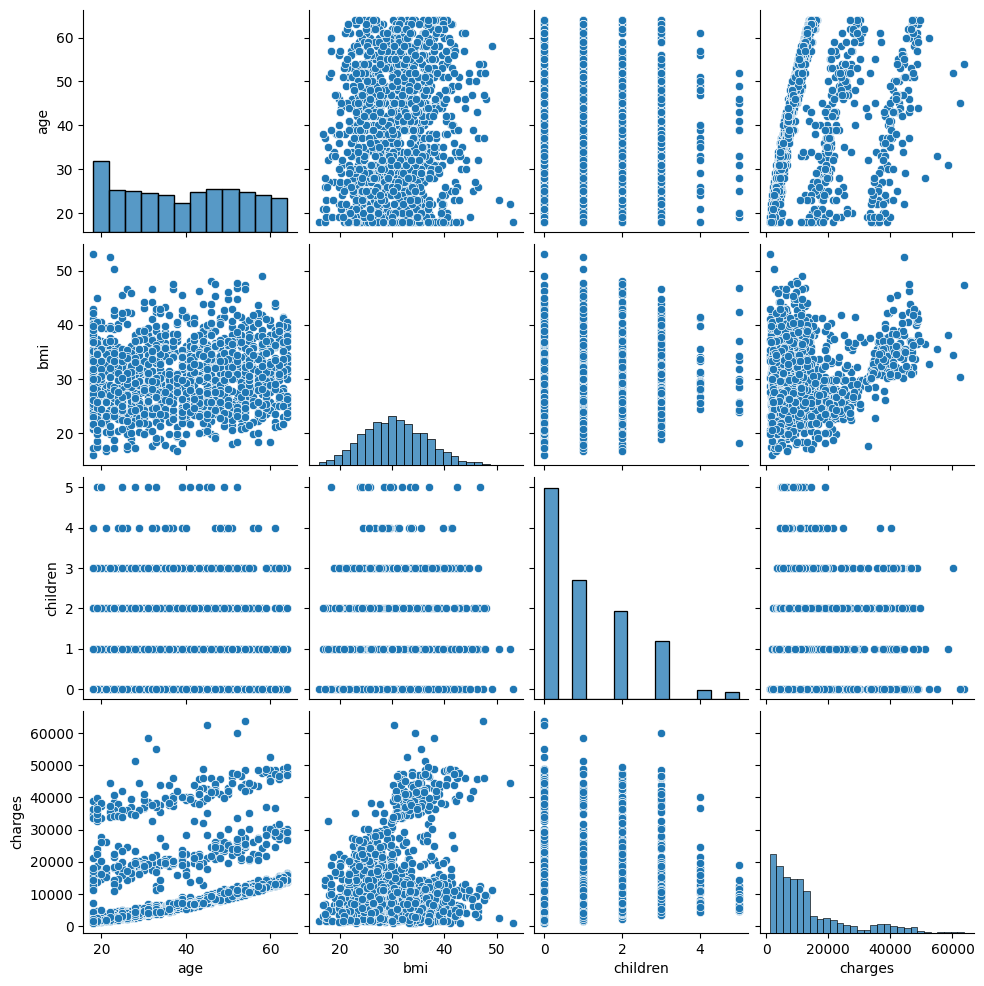

In [29]:
# Pairwise plot
sns.pairplot(df.select_dtypes(include="number"))

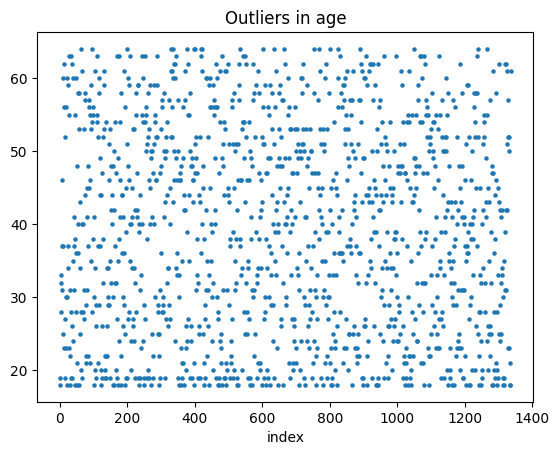

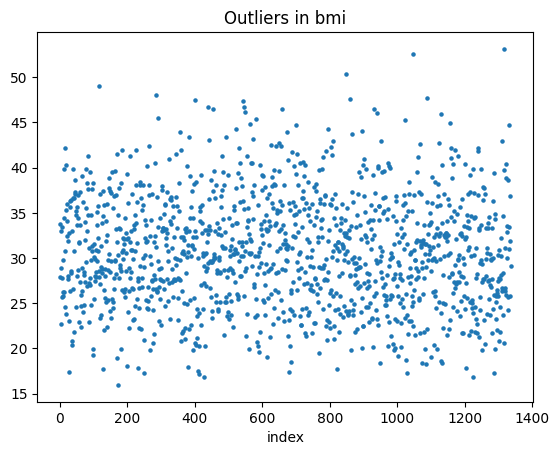

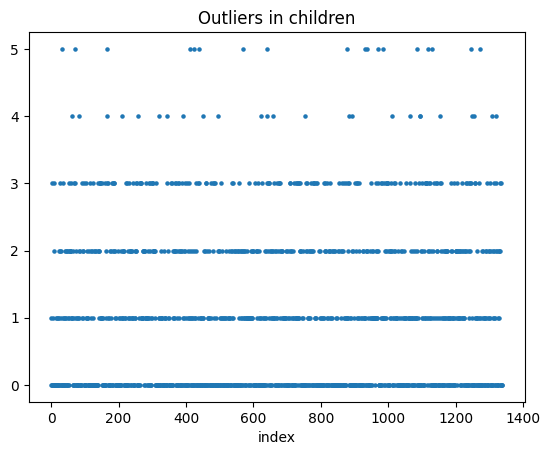

In [78]:
def scatter_outliers(df, col):    
    plt.figure()
    plt.scatter(df.index, df[col], s=5)
    plt.xlabel('index')
    #plt.yticks([])
    plt.ylabel
    plt.title(f"Outliers in {col}")
    plt.show()

for num_col in ['age','bmi','children']:
    scatter_outliers(df, num_col)

In [4]:
# Treating outliers:

# Treat outliers for skewed distributions using quantiles
def list_treat_outliers_quantile(df, col, lower_quantile, upper_quantile):
    #display('col=',col)
    lower = df[col].quantile(lower_quantile)
    upper = df[col].quantile(upper_quantile)
    df_outliers=df[(df[col]<lower) | (df[col]>upper)]
    outlier_count=df_outliers.shape[0]
    total_count=df.shape[0]
    df[col] = df[col].clip(lower, upper)
    ratio=outlier_count/total_count
    print('col=',col,'lower_quantile=',lower,' upper_quantile=',upper,'df_outliers.count=',outlier_count,'total records=',total_count,' ratio=',ratio)

from scipy.stats import zscore
# Treat outliers for normally distributed data using z-score
def list_treat_outliers_zscore(df, col):
    z_df=pd.DataFrame()
    z_df["z_score"] = zscore(df[col])

    mean = df[col].mean()
    std  = df[col].std()
    k = 3
    lower = mean - k * std
    upper = mean + k * std

    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print('col=',col,' lower=',lower,' upper=',upper,'outliers=',outliers)
    df[col] = df[col].clip(lower, upper)

list_treat_outliers_zscore(df, 'bmi') # Treating outliers in bmi using zscore, since it is normally distributed.
list_treat_outliers_quantile(df, 'age', 0.01, 0.99) # Treating outliers in age using quantile, since it is not normally distributed.
list_treat_outliers_quantile(df, 'children', 0.01, 0.99) # Treating outliers in children using quantile, since it is not normally distributed.


col= bmi  lower= 12.423793133836028  upper= 48.88921274192471 outliers=       age   sex        bmi  children smoker     region     charges
116    58  male  48.964857         0     no  southeast  11381.3254
847    23  male  48.964857         1     no  southeast   2438.0552
1047   22  male  48.964857         1    yes  southeast  44501.3982
1317   18  male  48.964857         0     no  southeast   1163.4627
col= age lower_quantile= 18.0  upper_quantile= 64.0 df_outliers.count= 0 total records= 1337  ratio= 0.0
col= children lower_quantile= 0.0  upper_quantile= 5.0 df_outliers.count= 0 total records= 1337  ratio= 0.0


In [5]:
# Splitting data into feature and target variable.
X = df.drop('charges', axis=1)
Y = df['charges']

In [27]:
# Splitting data into train and test sets.
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=3)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoders={}

for col in categorical_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    encoders[col] = le


array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)

In [85]:
X_train.head(3)

,age,sex,bmi,children,smoker,region
627,33,1,42.460000,1,0,2
16,52,0,30.780000,1,0,0
1037,45,0,30.495000,1,1,1


In [146]:
skewness = df[['age','bmi','children']].skew()
print(skewness)

age        0.054781
bmi        0.252228
children   0.937421
dtype: float64


In [10]:
#Scaling features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols=['age','bmi','children']

scaler.fit(X_train[cols])

def scale(input_df,cols):
    tmp_df=pd.DataFrame(scaler.transform(input_df[cols]), columns=cols, index=input_df.index)
    input_df[cols]=tmp_df[cols]
    return tmp_df

X_train[cols]=scale(X_train, cols)
X_test[cols]=scale(X_test, cols)

,age,sex,bmi,children,smoker,region
856,0.631057,0,0.383590,-0.924563,1,2
778,-0.306033,1,0.582974,1.500599,0,2
65,-1.459374,0,-0.310135,-0.924563,0,3


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def predict_and_evaluate(model, X_input, Y_input):
    Y_pred = model.predict(X_input)
    mse = mean_squared_error(Y_input, Y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_input, Y_pred)
    r2 = r2_score(Y_input, Y_pred)


    n = X_input.shape[0]         
    p = X_input.shape[1]          
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f'MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}, Adjusted R2: {adj_r2:.4f}')


In [149]:
#Linear Regression Model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, Y_train)

print("Training Set Evaluation:")
predict_and_evaluate(lr, X_test, Y_test)
print("Test Set Evaluation:")
predict_and_evaluate(lr, X_train, Y_train)

Training Set Evaluation:
MSE: 36995090.63, RMSE: 6082.36, MAE: 4324.77, R2: 0.7393, Adjusted R2: 0.7345
Test Set Evaluation:
MSE: 36538589.78, RMSE: 6044.72, MAE: 4105.43, R2: 0.7533, Adjusted R2: 0.7518


In [150]:
# KNN Regressor
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, Y_train)
Y_pred=knn.predict(X_test)
print("KNN Regressor Test Set Evaluation:")
predict_and_evaluate(knn, X_test, Y_test)
print("KNN Regressor Training Set Evaluation:")
predict_and_evaluate(knn, X_train, Y_train)

KNN Regressor Test Set Evaluation:
MSE: 36576914.89, RMSE: 6047.89, MAE: 3702.09, R2: 0.7422, Adjusted R2: 0.7375
KNN Regressor Training Set Evaluation:
MSE: 30239656.87, RMSE: 5499.06, MAE: 3259.93, R2: 0.7958, Adjusted R2: 0.7946


In [14]:
#Decision Tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=42)
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.05, 0.1]
}

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,                        
    scoring='neg_mean_squared_error',
    n_jobs=3)

grid_search.fit(X_train, Y_train)

display("Best Parameters:", grid_search.best_params_)
display("Best CV Score:", grid_search.best_score_)
best_dt_model = grid_search.best_estimator_

print("Decision Tree Regressor Test Set Evaluation:")
predict_and_evaluate(best_dt_model, X_test, Y_test)
print("Decision Tree Regressor Training Set Evaluation:")
predict_and_evaluate(best_dt_model, X_train, Y_train)

'Best Parameters:'

{'ccp_alpha': 0.0,
 'max_depth': 4,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

'Best CV Score:'

-23404687.13435106

Decision Tree Regressor Test Set Evaluation:
MSE: 19301705.44, RMSE: 4393.37, MAE: 2627.49, R2: 0.8640, Adjusted R2: 0.8615
Decision Tree Regressor Training Set Evaluation:
MSE: 19773965.24, RMSE: 4446.79, MAE: 2652.11, R2: 0.8665, Adjusted R2: 0.8657


In [152]:
# SVR
from sklearn.svm import SVR
svr = SVR(
    kernel='rbf',   # radial basis function
    C=100,
    epsilon=0.1
)
svr.fit(X_train, Y_train)
print("SVR Test Set Evaluation:")
predict_and_evaluate(svr, X_test, Y_test)
print("SVR Training Set Evaluation:")
predict_and_evaluate(svr, X_train, Y_train)

SVR Test Set Evaluation:
MSE: 141664715.82, RMSE: 11902.30, MAE: 6397.44, R2: 0.0017, Adjusted R2: -0.0166
SVR Training Set Evaluation:
MSE: 151269875.64, RMSE: 12299.18, MAE: 6324.67, R2: -0.0214, Adjusted R2: -0.0275


In [15]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=2) 

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}  

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=3
) 

grid_search.fit(X_train, Y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
print("Random Forest Test Set Evaluation:")
predict_and_evaluate(best_rf, X_test, Y_test)
print("Random Forest Training Set Evaluation:")
predict_and_evaluate(best_rf, X_train, Y_train)

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best CV Score: 0.8513113969484584
Random Forest Test Set Evaluation:
MSE: 17923346.00, RMSE: 4233.60, MAE: 2420.80, R2: 0.8737, Adjusted R2: 0.8714
Random Forest Training Set Evaluation:
MSE: 17131009.12, RMSE: 4138.96, MAE: 2313.74, R2: 0.8843, Adjusted R2: 0.8836


In [155]:
# XGBoost
from xgboost import XGBRegressor
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective='reg:squarederror'
)  

xgb.fit(X_train, Y_train)
print("XGBoost Test Set Evaluation:")
predict_and_evaluate(xgb, X_test, Y_test)
print("XGBoost Training Set Evaluation:")
predict_and_evaluate(xgb, X_train, Y_train)

XGBoost Test Set Evaluation:
MSE: 19897519.34, RMSE: 4460.66, MAE: 2492.81, R2: 0.8598, Adjusted R2: 0.8572
XGBoost Training Set Evaluation:
MSE: 8021958.27, RMSE: 2832.31, MAE: 1532.53, R2: 0.9458, Adjusted R2: 0.9455


In [156]:
from sklearn.linear_model import ElasticNet
el = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=3)
el.fit(X_train, Y_train)
print("ElasticNet Test Set Evaluation:")
predict_and_evaluate(el, X_test, Y_test)
print("ElasticNet Training Set Evaluation:")
predict_and_evaluate(el, X_train, Y_train)

ElasticNet Test Set Evaluation:
MSE: 38594215.51, RMSE: 6212.42, MAE: 4665.26, R2: 0.7280, Adjusted R2: 0.7231
ElasticNet Training Set Evaluation:
MSE: 42046803.58, RMSE: 6484.35, MAE: 4706.33, R2: 0.7161, Adjusted R2: 0.7144


In [158]:
from sklearn.ensemble import BaggingRegressor

bagging = BaggingRegressor(
    estimator=best_dt_model,
    n_estimators=100,     # number of trees
    max_samples=0.8,      # % of rows per model
    max_features=1.0,     # % of features per model
    bootstrap=True,
    random_state=42,
    n_jobs=3
)

bagging.fit(X_train, Y_train)
print("Bagging Regressor Test Set Evaluation:")
predict_and_evaluate(bagging, X_test, Y_test)
print("Bagging Regressor Training Set Evaluation:")
predict_and_evaluate(bagging, X_train, Y_train)

Bagging Regressor Test Set Evaluation:
MSE: 17878740.30, RMSE: 4228.33, MAE: 2450.31, R2: 0.8740, Adjusted R2: 0.8717
Bagging Regressor Training Set Evaluation:
MSE: 18814848.47, RMSE: 4337.61, MAE: 2444.63, R2: 0.8730, Adjusted R2: 0.8722


In [159]:
from sklearn.ensemble import  VotingRegressor
voting_reg = VotingRegressor(
    estimators=[
        ('xgb', xgb),
        ('dt', best_dt_model),
        ('rf', best_rf)
    ]
)
voting_reg.fit(X_train, Y_train)
print("Voting Regressor Test Set Evaluation:")
predict_and_evaluate(voting_reg, X_test, Y_test)
print("Voting Regressor Training Set Evaluation:")
predict_and_evaluate(voting_reg, X_train, Y_train)


Voting Regressor Test Set Evaluation:
MSE: 18108841.40, RMSE: 4255.45, MAE: 2425.22, R2: 0.8724, Adjusted R2: 0.8701
Voting Regressor Training Set Evaluation:
MSE: 13865756.93, RMSE: 3723.68, MAE: 2090.96, R2: 0.9064, Adjusted R2: 0.9058


In [ ]:
import joblib
joblib.dump(best_rf, "best_rf.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoders, "label_encoders.pkl")

['label_encoder.pkl']

In [23]:
X_train.head(3) 


,age,sex,bmi,children,smoker,region
627,-0.450200,1,1.924285,-0.116175,0,2
16,0.919393,0,-0.000348,-0.116175,0,0
1037,0.414806,0,-0.047311,-0.116175,1,1


In [24]:
df.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [26]:
df['sex'].unique()

array(['female', 'male'], dtype=object)